# 1. Import needed libraries

In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")

# 2. Preprocessing

## 2.1 Load data

In [5]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [6]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [7]:
tr_df = train_df('Training')

In [8]:
tr_df

,Class Path,Class
0,Training\Astrocitoma\005_big_gallery.jpeg,Astrocitoma
1,Training\Astrocitoma\006be184fb63e8806d40bc970...,Astrocitoma
2,Training\Astrocitoma\006_big_gallery.jpeg,Astrocitoma
3,Training\Astrocitoma\007_big_gallery.jpeg,Astrocitoma
4,Training\Astrocitoma\008_big_gallery.jpeg,Astrocitoma
...,...,...
6638,Training\Tuberculoma\f132bfdf20476efa7b6c99099...,Tuberculoma
6639,Training\Tuberculoma\f19e3f394493bf91cf319d4d1...,Tuberculoma
6640,Training\Tuberculoma\f98a6a2bf475a469626f04a81...,Tuberculoma
6641,Training\Tuberculoma\fd57affc10044d67310769b90...,Tuberculoma


In [9]:
ts_df = test_df('Testing')

In [10]:
ts_df

,Class Path,Class
0,Testing\Astrocitoma\007_big_gallery.jpeg,Astrocitoma
1,Testing\Astrocitoma\008_big_gallery.jpeg,Astrocitoma
2,Testing\Astrocitoma\009_big_gallery.jpeg,Astrocitoma
3,Testing\Astrocitoma\010_big_gallery.jpeg,Astrocitoma
4,Testing\Astrocitoma\011_big_gallery.jpeg,Astrocitoma
...,...,...
2085,Testing\Tuberculoma\d4bfc3b8352f11d35d509fb110...,Tuberculoma
2086,Testing\Tuberculoma\dbd5e374c36157459e42bd9397...,Tuberculoma
2087,Testing\Tuberculoma\f1dd9712c9eda13c0bf31be1f9...,Tuberculoma
2088,Testing\Tuberculoma\f208bfdc71cac60e46a2abe3ca...,Tuberculoma


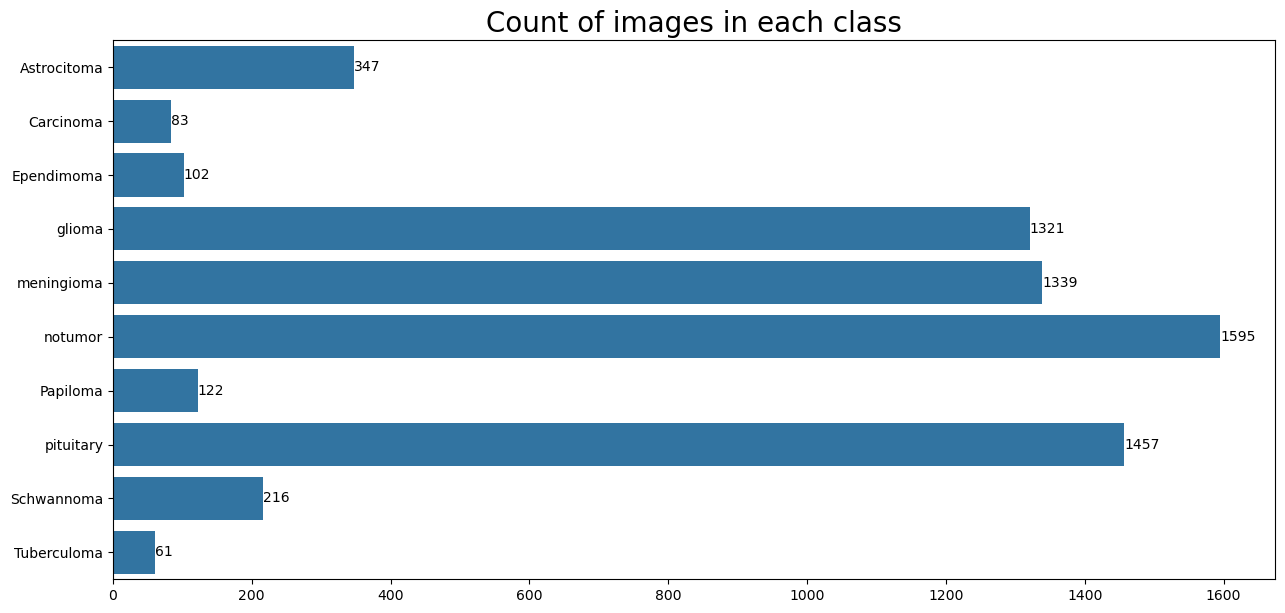

In [11]:

plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

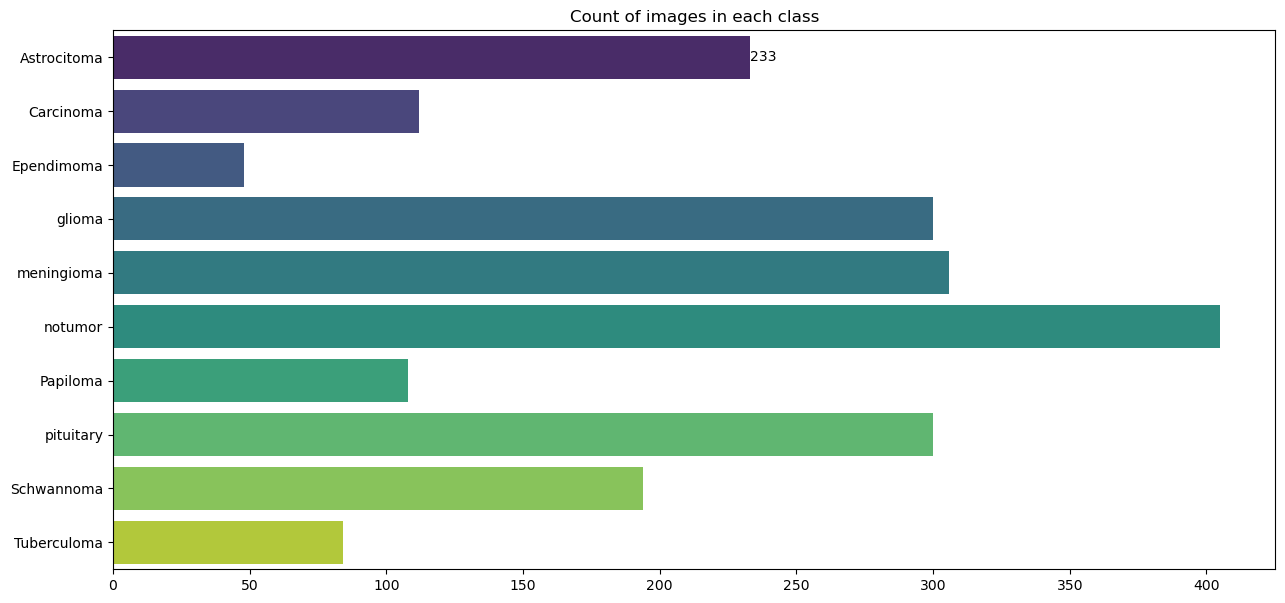

In [12]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

## 2.2 Split data into train, test, valid

In [14]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [15]:
valid_df

,Class Path,Class
1509,Testing\Papiloma\ebe3e347dac5be006bec359ed4076...,Papiloma
2007,Testing\Tuberculoma\03ad5701df444374ddb9f73c01...,Tuberculoma
1133,Testing\notumor\Te-no_0134.jpg,notumor
35,Testing\Astrocitoma\13989b9b62eee23e2f52d95fae...,Astrocitoma
1052,Testing\notumor\Te-no_0053.jpg,notumor
...,...,...
600,Testing\glioma\Te-gl_0207.jpg,glioma
229,Testing\Astrocitoma\IMG-0007-00015_big_gallery...,Astrocitoma
574,Testing\glioma\Te-gl_0181.jpg,glioma
1055,Testing\notumor\Te-no_0056.jpg,notumor


## 2.3 Data preprocessing

In [17]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 6643 validated image filenames belonging to 10 classes.
Found 1044 validated image filenames belonging to 10 classes.
Found 1045 validated image filenames belonging to 10 classes.


## 2.4 Getting samples from data

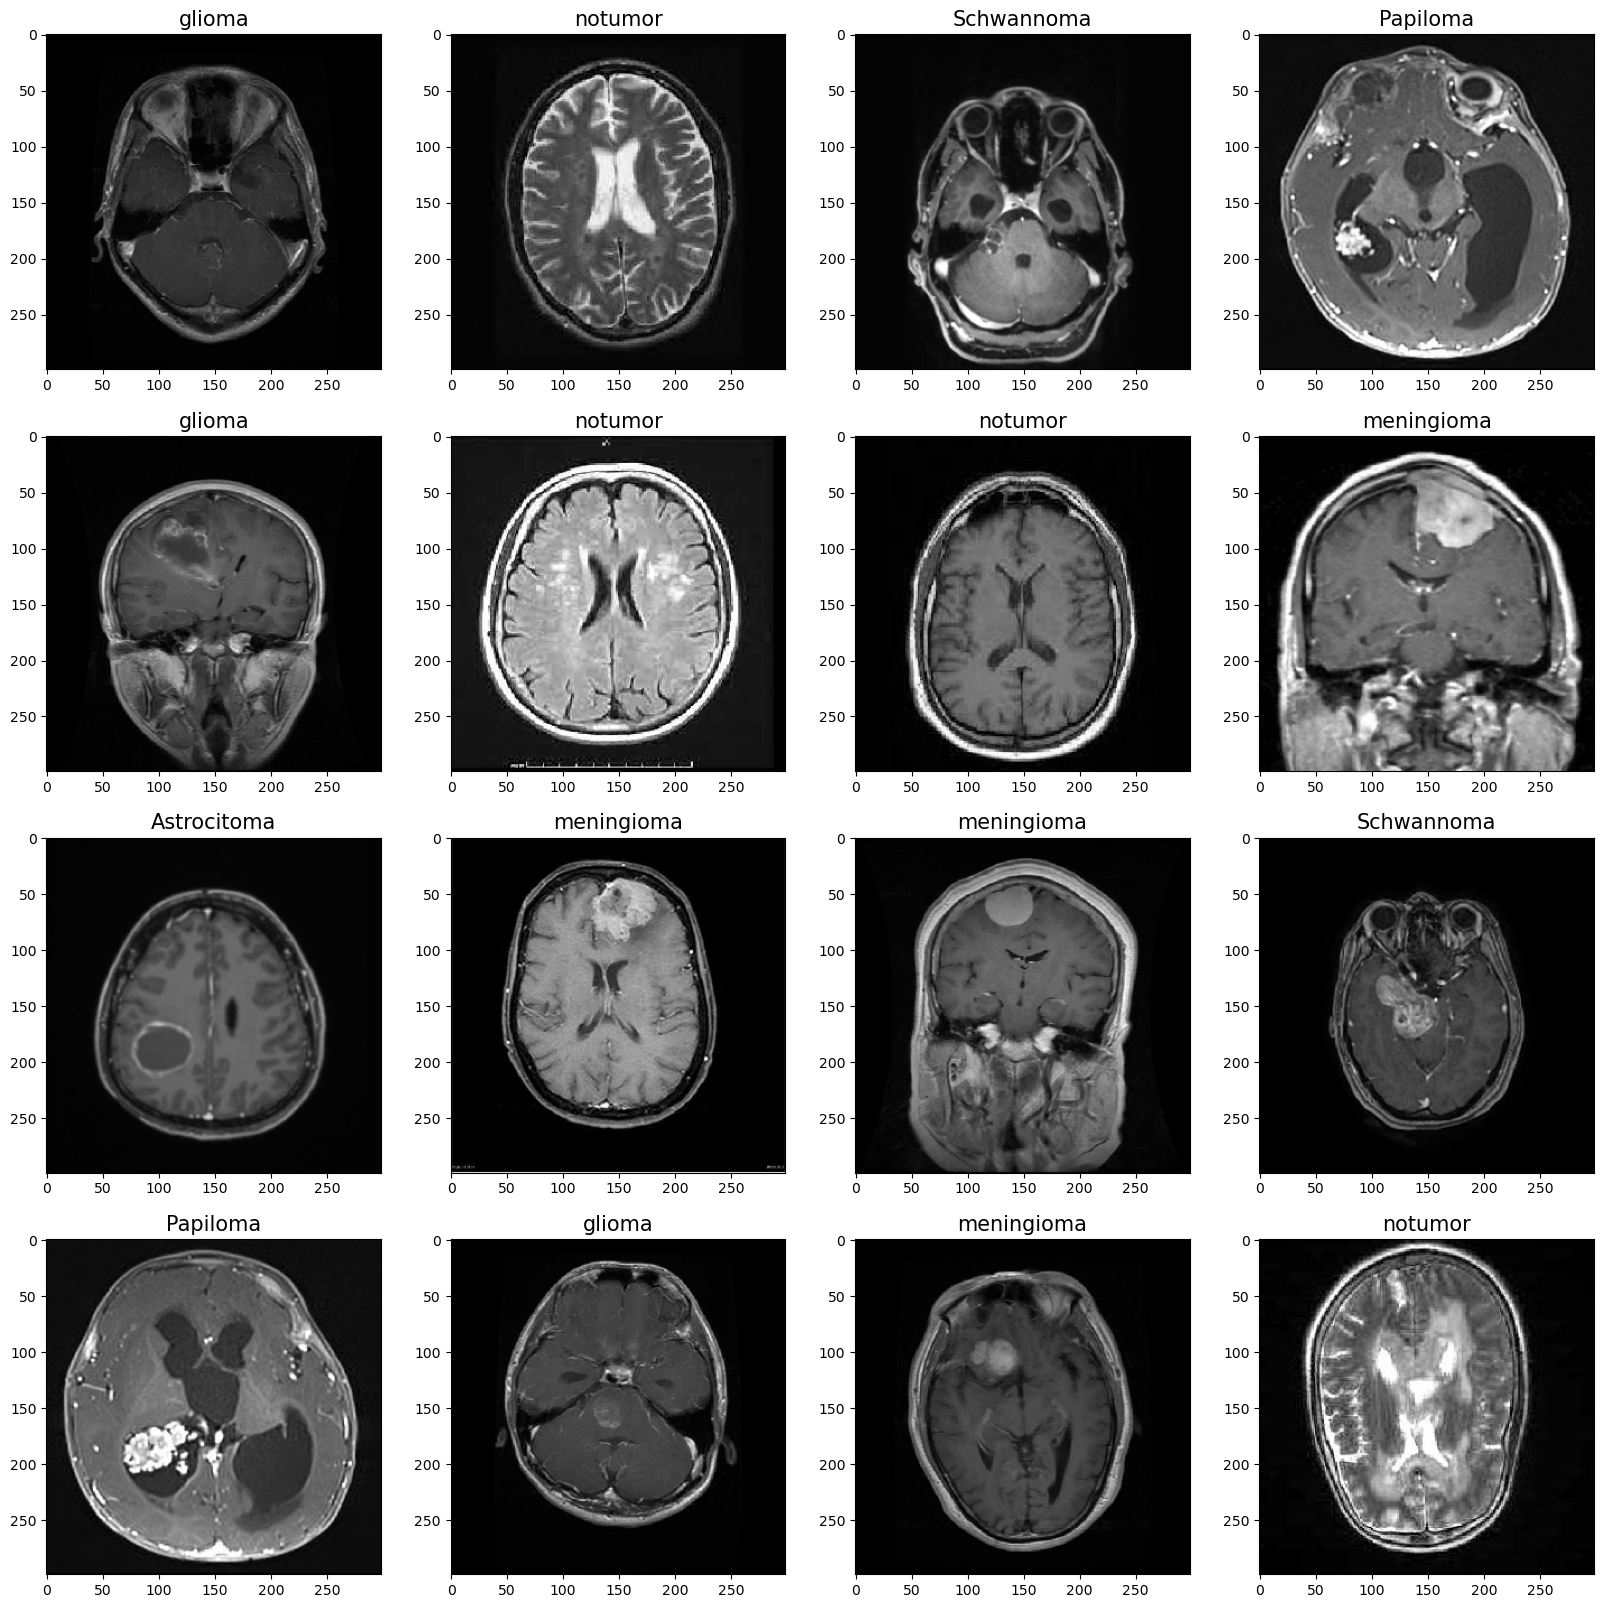

In [19]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

# 3. Building Deep Learning Model

In [21]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')
    
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(10, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,125,042 (80.59 MB)

 Trainable params: 21,070,514 (80.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

# 4. Training

In [25]:
hist = model.fit(tr_gen,
                 epochs=4,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/4
208/208 ━━━━━━━━━━━━━━━━━━━━ 2181s 10s/step - accuracy: 0.9760 - loss: 0.0766 - precision: 0.9836 - recall: 0.9703 - val_accuracy: 0.8544 - val_loss: 0.4880 - val_precision: 0.8823 - val_recall: 0.8400
Epoch 2/4
208/208 ━━━━━━━━━━━━━━━━━━━━ 2180s 10s/step - accuracy: 0.9928 - loss: 0.0301 - precision: 0.9939 - recall: 0.9911 - val_accuracy: 0.8726 - val_loss: 0.4752 - val_precision: 0.8821 - val_recall: 0.8602
Epoch 3/4
208/208 ━━━━━━━━━━━━━━━━━━━━ 2273s 11s/step - accuracy: 0.9890 - loss: 0.0408 - precision: 0.9904 - recall: 0.9874 - val_accuracy: 0.8688 - val_loss: 0.4377 - val_precision: 0.8928 - val_recall: 0.8534
Epoch 4/4
208/208 ━━━━━━━━━━━━━━━━━━━━ 2246s 11s/step - accuracy: 0.9960 - loss: 0.0156 - precision: 0.9963 - recall: 0.9948 - val_accuracy: 0.8975 - val_loss: 0.4358 - val_precision: 0.9054 - val_recall: 0.8889


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model.save('model.keras')

In [29]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

## 4.1 Visualize model performance

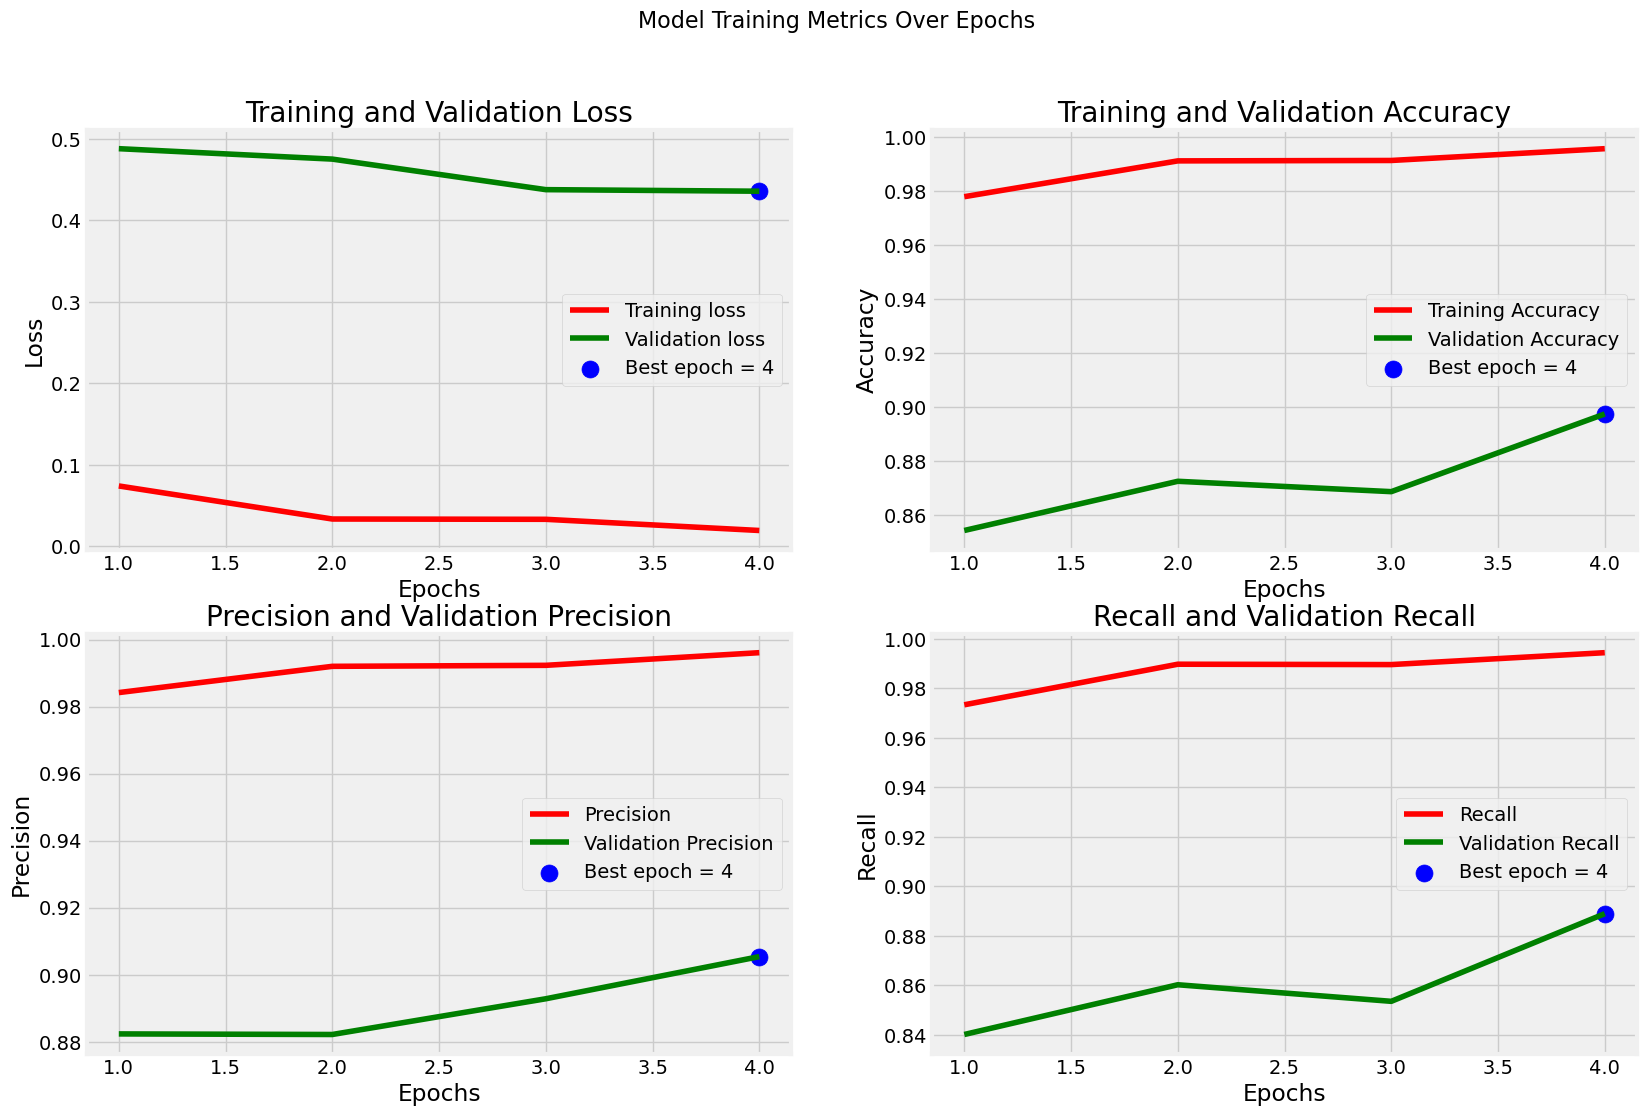

In [31]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

# 5. Testing and Evaluation

## 5.1 Evaluate

In [33]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


208/208 ━━━━━━━━━━━━━━━━━━━━ 540s 3s/step - accuracy: 0.9977 - loss: 0.0070 - precision: 0.9986 - recall: 0.9975
33/33 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9088 - loss: 0.3834 - precision: 0.9156 - recall: 0.8979
66/66 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.8810 - loss: 0.5503 - precision: 0.8959 - recall: 0.8691
Train Loss: 0.0057
Train Accuracy: 99.82%
--------------------
Validation Loss: 0.4270
Validation Accuracy: 89.94%
--------------------
Test Loss: 0.5252
Test Accuracy: 89.19%


In [34]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

66/66 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step


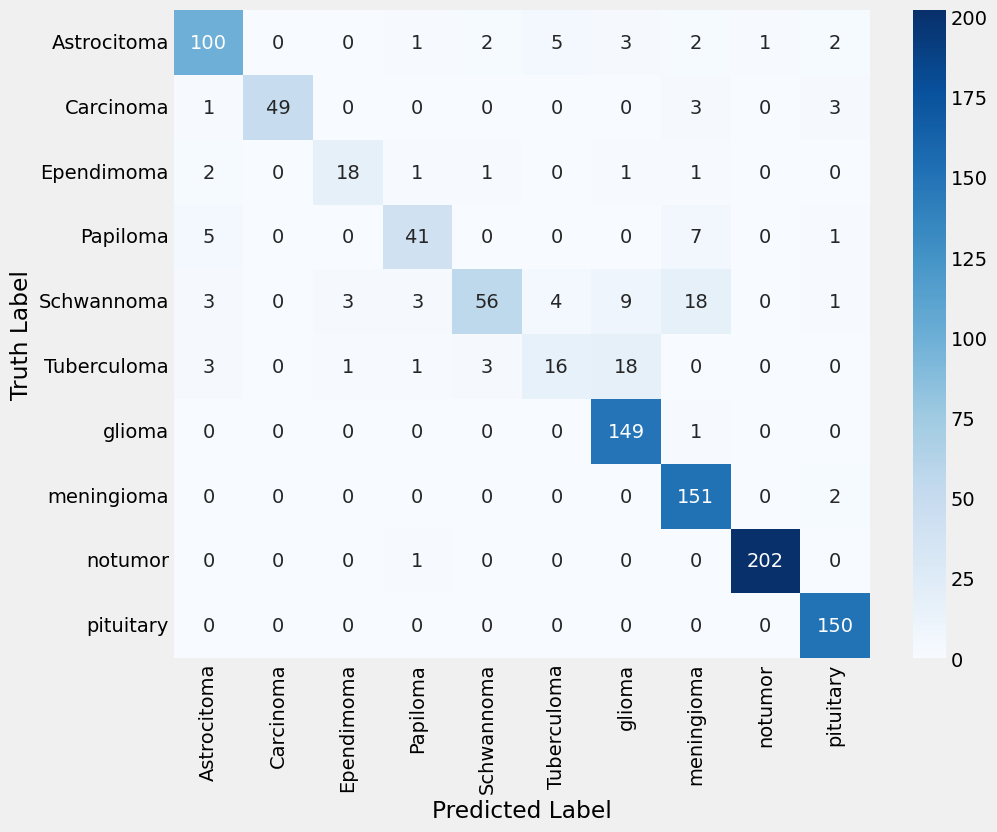

In [35]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [36]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       116
           1       1.00      0.88      0.93        56
           2       0.82      0.75      0.78        24
           3       0.85      0.76      0.80        54
           4       0.90      0.58      0.70        97
           5       0.64      0.38      0.48        42
           6       0.83      0.99      0.90       150
           7       0.83      0.99      0.90       153
           8       1.00      1.00      1.00       203
           9       0.94      1.00      0.97       150

    accuracy                           0.89      1045
   macro avg       0.87      0.82      0.83      1045
weighted avg       0.89      0.89      0.88      1045



## 5.2 Testing

In [5]:
class_dict = [
        "Astrocitoma",
        "Carcinoma",
        "Ependimoma",
        "Papilloma",
        "Schwannoma",
        "Tuberculoma",
        "Glioma",
        "Meningioma",
        "Not Tumor",
        "Pituitary",
    ]

def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

In [3]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

model = load_model('model.keras')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,266,072 (241.34 MB)

 Trainable params: 21,070,514 (80.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 42,141,030 (160.76 MB)